In [1]:
import torch
import torchvision

## Device Agnostic Code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Setting up Transformer and Augmentation 

In [3]:
from torchvision import transforms

# Define the transformation pipeline
transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image with 50% probability
    transforms.ToTensor()  # Convert the image to a tensor
])

## Download the FashionMNIST Data

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = torchvision.datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform =transformer
)
test_data = torchvision.datasets.FashionMNIST(
    root='data',
    train = False,
    download = True,
    transform = transformer
)

## Getting instance of random Data(for easier Visualization)

In [5]:
import random
random_data = random.randint(0,len(train_data)-1)

images,label = train_data[random_data]
images.shape,label

(torch.Size([1, 28, 28]), 5)

## Converting to DataLoader

In [6]:
from torch.utils.data import DataLoader
import os 

Batch_size = 32

train_dataloader = DataLoader(batch_size=Batch_size,dataset = train_data,shuffle = False)
test_dataloader = DataLoader(batch_size = Batch_size,dataset = test_data,shuffle = True,)

## Getting the visulaization of the data os instance

(-0.5, 27.5, 27.5, -0.5)

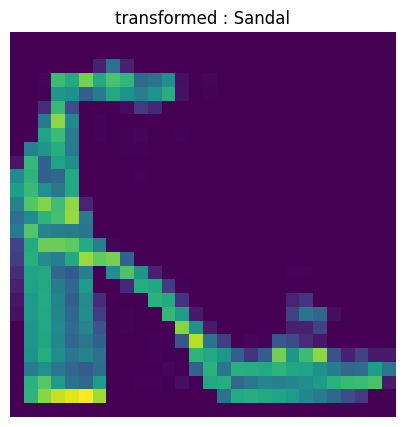

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))
plt.imshow(images.squeeze())
plt.title(f"transformed : {train_data.classes[label]}")
plt.axis("off")

## Making the two Model to train the data

In [8]:
from torch import nn

# simple multilayer percepetron (MLP)
class model_linear(nn.Module):
    def __init__(self,
                input:int,       # input size (28*28 = 784 for FashionMNIST)
                hidden_units_1:int,
                hidden_units_2:int,
                output:int):     # output size (10 classes for FashionMNIST)
        super().__init__()
        
        self.flatten = nn.Flatten()  # Flatten the input image
        self.linear_layer_1 = nn.Sequential(
            nn.Linear(in_features=input, out_features=hidden_units_1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2)
        )
        self.linear_layer_2 = nn.Sequential(
            nn.Linear(in_features=hidden_units_2, out_features=hidden_units_1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2)
        )
        self.linear_layer_3 = nn.Sequential(
            nn.Linear(in_features=hidden_units_2, out_features=hidden_units_1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_1, out_features=output)
        )

    def forward(self, x):
        return self.linear_layer_3(self.linear_layer_2(self.linear_layer_1(self.flatten(x))))


# Simple CNN
class model_CNN(nn.Module):
    def __init__(self,
                input:int,
                hidden_units:int,
                output:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1), # values we can set ourself in our NN's are called hyperparameter
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output)
        )
    def forward(self,x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

## Making the Instances of the models

In [9]:
Linear_model = model_linear(input = 28*28,
                           hidden_units_1 = 10,
                           hidden_units_2 = 20,
                           output = len(train_data.classes)).to(device)
CNN_model = model_CNN(input= 1,
                     hidden_units = 8,
                     output = len(train_data.classes)).to(device)

In [10]:
print(len(train_data.classes))

10


## Loss function Optimizer and accuracy_function

In [11]:
loss_fn = nn.CrossEntropyLoss()
model = CNN_model
optimizer_Linear = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer_CNN = torch.optim.Adam(model.parameters(), lr=0.001)
def accuracy_fn(y_pred,y_true):
  correct = torch.eq(y_pred,y_true).sum().item()
  acc = (correct/len(y_true))*100
  return acc

## Fucntionizing the training testing and evaulating

In [12]:
device = "cuda" 
def train_model(model: torch.nn.Module,
                data_loader : torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device : torch.device = device
                ):
  train_loss,train_acc = 0,0
  model.train()

  for batch,(X,y) in enumerate(data_loader):
    X,y = X.to(device),y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred,y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = y,y_pred = y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"train_loss: {train_loss:.5f} | train_acc: {train_acc:.2f}%")

def testing_model(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  accuracy_fn,
                  device : torch.device = device):
  test_loss,test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X_test,y_test in data_loader:
      X_test,y_test = X_test.to(device),y_test.to(device)
      test_pred = model(X_test)
      test_loss += loss_fn(test_pred,y_test)
      test_acc += accuracy_fn(y_true = y_test,y_pred = test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"test_loss: {test_loss:.5f} | test_acc: {test_acc:.2f}%")

def eval_model(model: torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  loss,acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y = X.to(device),y.to(device)
      y_pred = model(X)

      loss = loss_fn(y_pred,y)
      acc += accuracy_fn(y_true = y,y_pred = y_pred.argmax(dim= 1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model name": model.__class__.__name__,
          "loss": loss.item(),
          "acc": acc}

def Train_time(start:float,
               end:float,
               device: torch.device = None):
  total_time = end-start
  print(f"Train time on {device} is {total_time:.3f} seconds")
  return total_time

In [13]:
from pathlib import Path

MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# create model save path
# saving and loading model
MODEL_NAME = "CNN_Model_state_dict.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

## Training and Testing Phase of Linear model 

In [14]:
from tqdm import tqdm

from timeit import default_timer as timer
train_time_start_model =timer()
epochs = 5
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ...")
  train_model(model = Linear_model,
              data_loader = train_dataloader,
              loss_fn = loss_fn,
              optimizer = optimizer_Linear,
              accuracy_fn = accuracy_fn,
              device = device)
  testing_model(model = Linear_model,
                data_loader = test_dataloader,
                loss_fn = loss_fn,
                accuracy_fn = accuracy_fn,
                device = device)
  train_time_end_model = timer()
  Train_time(start = train_time_start_model,
             end = train_time_end_model,
             device = device)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 0 ...
train_loss: 2.31554 | train_acc: 7.89%


 20%|████████████████▊                                                                   | 1/5 [00:11<00:47, 11.91s/it]

test_loss: 2.31554 | test_acc: 7.92%
Train time on cuda is 11.914 seconds
Epoch: 1 ...
train_loss: 2.31554 | train_acc: 7.89%


 40%|█████████████████████████████████▌                                                  | 2/5 [00:26<00:40, 13.59s/it]

test_loss: 2.31547 | test_acc: 7.98%
Train time on cuda is 26.683 seconds
Epoch: 2 ...
train_loss: 2.31554 | train_acc: 7.80%


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:41<00:28, 14.36s/it]

test_loss: 2.31549 | test_acc: 8.05%
Train time on cuda is 41.946 seconds
Epoch: 3 ...
train_loss: 2.31553 | train_acc: 7.81%


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:55<00:14, 14.06s/it]

test_loss: 2.31548 | test_acc: 8.02%
Train time on cuda is 55.564 seconds
Epoch: 4 ...
train_loss: 2.31554 | train_acc: 7.82%


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.85s/it]

test_loss: 2.31546 | test_acc: 7.81%
Train time on cuda is 69.274 seconds


## Training and Testing Phase of CNN model 

In [25]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# load the save dict if available
try:
    checkpoint = torch.load(MODEL_SAVE_PATH)
    CNN_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer_CNN.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint.get('epoch', 0)
    print("Checkpoint loaded successfully. Starting from epoch:", start_epoch)
except FileNotFoundError:
    print(f"No checkpoint found at {MODEL_SAVE_PATH}. Starting training from scratch...")
    start_epoch = 0

from timeit import default_timer as timer
train_time_start_model =timer()
indx = 2
epochs = 4
for i in tqdm(range(indx)):
    for epoch in tqdm(range(epochs)):
      print(f"Epoch: {epoch} ...")
      train_model(model = CNN_model,
                  data_loader = train_dataloader,
                  loss_fn = loss_fn,
                  optimizer = optimizer_CNN,
                  accuracy_fn = accuracy_fn,
                  device = device)
      testing_model(model = CNN_model,
                    data_loader = test_dataloader,
                    loss_fn = loss_fn,
                    accuracy_fn = accuracy_fn,
                    device = device)

    torch.save({
        'model_state_dict': CNN_model.state_dict(),
        'optimizer_state_dict': optimizer_CNN.state_dict(),
    }, MODEL_SAVE_PATH)
    # loading model
    checkpoint = torch.load(MODEL_SAVE_PATH)
    CNN_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer_CNN.load_state_dict(checkpoint['optimizer_state_dict'])
train_time_end_model = timer()
Train_time(start = train_time_start_model,
         end = train_time_end_model,
         device = device)


Checkpoint loaded successfully. Starting from epoch: 0


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Epoch: 0 ...
train_loss: 0.19348 | train_acc: 92.94%



 25%|█████████████████████                                                               | 1/4 [00:12<00:37, 12.55s/it]

test_loss: 0.27843 | test_acc: 90.70%
Epoch: 1 ...
train_loss: 0.19241 | train_acc: 93.03%



 50%|██████████████████████████████████████████                                          | 2/4 [00:24<00:24, 12.16s/it]

test_loss: 0.27630 | test_acc: 90.69%
Epoch: 2 ...
train_loss: 0.19159 | train_acc: 93.10%



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:39<00:13, 13.27s/it]

test_loss: 0.28204 | test_acc: 90.69%
Epoch: 3 ...
train_loss: 0.19305 | train_acc: 92.93%



 50%|██████████████████████████████████████████                                          | 1/2 [00:52<00:52, 52.71s/it]

test_loss: 0.28736 | test_acc: 90.94%



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Epoch: 0 ...
train_loss: 0.19151 | train_acc: 92.98%



 25%|█████████████████████                                                               | 1/4 [00:12<00:37, 12.61s/it]

test_loss: 0.28436 | test_acc: 90.71%
Epoch: 1 ...
train_loss: 0.19148 | train_acc: 93.03%



 50%|██████████████████████████████████████████                                          | 2/4 [00:27<00:27, 13.74s/it]

test_loss: 0.29441 | test_acc: 90.50%
Epoch: 2 ...
train_loss: 0.19299 | train_acc: 92.99%



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:41<00:13, 13.87s/it]

test_loss: 0.28047 | test_acc: 90.76%
Epoch: 3 ...
train_loss: 0.19122 | train_acc: 93.06%



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:49<00:00, 54.54s/it]

test_loss: 0.28300 | test_acc: 90.47%
Train time on cuda is 109.083 seconds


109.08268119999957

## Evaluating the models  

In [24]:
linear_model_result = eval_model(model = Linear_model,
          data_loader = test_dataloader,
          loss = loss_fn,
          accuracy_fn = accuracy_fn,
          device = device),
CNN_model_results = eval_model(model = CNN_model,
          data_loader = test_dataloader,
          loss = loss_fn,
          accuracy_fn = accuracy_fn,
          device = device)
linear_model_result,CNN_model_results

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 253.39it/s]


(({'model name': 'model_linear',
   'loss': 0.007267920766025782,
   'acc': 7.797523961661342},),
 {'model name': 'model_CNN',
  'loss': 0.0006585402879863977,
  'acc': 90.34544728434504})

## Plotting the loss curves

## Results

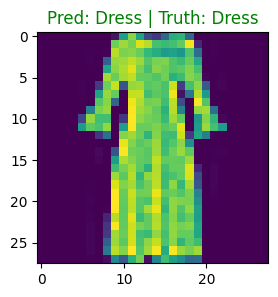

In [26]:
# Testing random testing
def testing_function(model:torch.nn.Module,
                    data:list,
                    device: torch.device = device):
    pred_probs = []
    model.to(device)
    with torch.inference_mode():
        for sample in data:
          sample = torch.unsqueeze(sample,dim=0).to(device)
          pred_logit = model(sample)
          pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
          pred_probs.append(pred_prob.cpu())
        return torch.stack(pred_probs)
test_sample = []
test_labels =[]
for sample,label in random.sample(list(test_data),k=9):
    test_sample.append(sample)
    test_labels.append(label)

# mkaing prediction
test_pred = testing_function(model=CNN_model,
                            data=test_sample)
test_class = test_pred.argmax(dim=1)

num = 3
plt.figure(figsize=(3,3))
plt.imshow(test_sample[num].squeeze())
pred_label = train_data.classes[test_class[num]]
true_label = train_data.classes[test_labels[num]]

title_text = f"Pred: {pred_label} | Truth: {true_label}"

# Set title color based on prediction accuracy
if pred_label == true_label:
    plt.title(title_text, fontsize=12, color="green")  # Green for correct predictions
else:
    plt.title(title_text, fontsize=12, color="red")    # Red for incorrect predictions

# Hide axis for clarity
# plt.axis('off')
plt.show()

In [27]:
!pip freeze > requirements.txt
